In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import networkx as nx

import graph_delineator.delineate as gd

In [2]:
# Define MERIT data directories
merit_dirs = {
    'basins': Path('/nas/cee-ice/data/MERIT'),
    'flow_dir': Path('/nas/cee-ice/data/MERIT-Hydro/processed/dir/'),
    'flow_acc': Path('/nas/cee-ice/data/MERIT-Hydro/processed/upg/')
}

# Load gauges
# gauges_csv = Path('/nas/cee-water/cjgleason/ted/graph_delineator/data/test.csv')
gauges_csv = Path('/nas/cee-water/cjgleason/ted/graph_delineator/data/clamped_manual_matchups.csv')

In [2]:
gd.delineate_watershed(gauges_csv, merit_dirs, 100, save_plots=True)


GRAPH-BASED WATERSHED DELINEATION
Data output directory: /nas/cee-water/cjgleason/ted/graph_delineator/data/clamped_manual_matchups

Processing Pfafstetter Basin 2 (contains 288 outlets)
Processing outlet EAUF-A3750050 (51 gauges)
Processing outlet EAUF-A8500610 (51 gauges)
Processing outlet EAUF-A8612020 (1 gauges)
Processing outlet EAUF-A9400001 (17 gauges)
Processing outlet EAUF-A9532050 (1 gauges)
Processing outlet EAUF-A9942020 (5 gauges)
Processing outlet EAUF-B7200000 (41 gauges)
Processing outlet EAUF-B7322010 (2 gauges)
Processing outlet EAUF-D0192230 (8 gauges)
Processing outlet EAUF-E2400411 (9 gauges)
Processing outlet EAUF-E3811265 (7 gauges)
Processing outlet EAUF-E4035710 (4 gauges)
Processing outlet EAUF-E4306010 (2 gauges)
Processing outlet EAUF-E4905710 (1 gauges)
Processing outlet EAUF-E5108212 (1 gauges)
Processing outlet EAUF-E5205710 (1 gauges)
Processing outlet EAUF-E5300213 (3 gauges)
Processing outlet EAUF-E5400310 (4 gauges)
Processing outlet EAUF-E5410001 (1


KeyboardInterrupt


KeyboardInterrupt



In [ ]:
debug

In [ ]:
"UKEA-694039" # single gauge with weird location

In [3]:
all_gauges = gd.load_gauges(gauges_csv)
megabasins_outlets = gd.get_pfaf1_outlet_dict(all_gauges)

b = False
for megabasin_id, outlet_dict in megabasins_outlets.items():
    for outlet_id, outlet_gauge_ids in outlet_dict.items():   

        if outlet_id != 'EAUF-E5300213':
            continue
            
        print(outlet_id)
        pfaf1_catchments, pfaf1_rivers = gd.load_basin_data(megabasin_id, merit_dirs)
        
        gauges = all_gauges[all_gauges["id"].isin(outlet_gauge_ids)]
        gauges = gd.set_gauge_area_range(gauges, pfaf1_rivers)

        final_comid = gauges[gauges['id'] == outlet_id]['COMID'].item()
        comids = gd.get_network_comids(final_comid,  pfaf1_rivers)

        catchments = pfaf1_catchments.loc[pfaf1_catchments.index.isin(comids)]
        rivers = pfaf1_rivers.loc[pfaf1_rivers.index.isin(comids)]
        
        G = gd.build_graph_with_geometries(catchments, rivers)

        b = True
        break
    
    if b:
        break

ERROR! Session/line number was not unique in database. History logging moved to new session 5779
EAUF-E5300213


<Axes: >

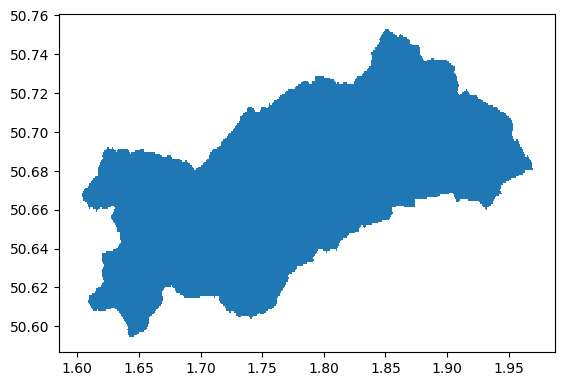

In [5]:
catchments.plot()

In [6]:
gauge_info = {}
node_replacements = {}

gauges['node_id'] = gauges['COMID'].astype(str)
gauges = gauges.sort_values(['node_id', 'position'], ascending=False)
gauges

,id,lng,lat,position,COMID,outlet_id,geometry,pfaf1,min_area_km2,max_area_km2,node_id
670,EAUF-E5310220,1.633298,50.680733,0.951244,23012301,EAUF-E5300213,POINT (1.6333 50.68073),2,0.0,211.903155,23012301
668,EAUF-E5300210,1.767580,50.681204,0.433031,23012301,EAUF-E5300213,POINT (1.76758 50.6812),2,0.0,211.903155,23012301
669,EAUF-E5300213,1.873947,50.703328,0.063331,23012301,EAUF-E5300213,POINT (1.87395 50.70333),2,0.0,211.903155,23012301


In [10]:
from graph_delineator.split_catchment import split_catchment_raster

In [14]:
merit_dirs

{'basins': PosixPath('/nas/cee-ice/data/MERIT'),
 'flow_dir': PosixPath('/nas/cee-ice/data/MERIT-Hydro/processed/dir'),
 'flow_acc': PosixPath('/nas/cee-ice/data/MERIT-Hydro/processed/upg')}

In [17]:
pfaf2_id = 23
MERIT_RES = 0.000833333  # 3 arc second resolution in degrees
TINY_AREA_THRESHOLD_KM2 = 0.5 

for _, gauge in gauges.iterrows():
    gauge_id = str(gauge["id"])

    # Follow the replacement chain to find current node
    original_node_id = gauge["node_id"]
    current_node_id = original_node_id
    while current_node_id in node_replacements:
        current_node_id = node_replacements[current_node_id]

    # Get the current polygon (may have been split already)
    current_polygon = G.nodes[current_node_id]["polygon"]

    gauge_polygon, is_leaf = split_catchment_raster(
        gauge=gauge.to_dict(),
        basin=pfaf2_id,
        catchment_poly=current_polygon,
        flow_dir_path=merit_dirs['flow_dir'],
        flow_acc_path=merit_dirs['flow_acc'],
    )

    is_leaf = False

    
    if gauge_polygon is None:
        # Failed, reason will be logged by fn
        continue

    if gauge_polygon == current_polygon:
        # No split needed. Convert the node to a gauge
        gd.convert_node_to_gauge(G, gauge_id, gauge["lat"], gauge["lng"], current_node_id)
        # Track that this node was replaced
        node_replacements[current_node_id] = gauge_id
        gauge_info[gauge_id] = {
            "original_node": original_node_id, 
            "current_node": current_node_id, 
            "method": "replace",
        }
        continue

    # Calculate remainder
    remainder_polygon = current_polygon.difference(gauge_polygon)
    remainder_polygon = remainder_polygon.buffer(-MERIT_RES / 2).buffer(MERIT_RES / 2)

    if is_leaf:
        gd.add_leaf_gauge_to_graph(
            G,
            gauge_id,
            gauge['lat'],
            gauge['lng'],
            gauge_polygon,
            remainder_polygon,
            current_node_id
        )
    else:
        gd.insert_gauge_into_graph(
            G,
            gauge_id,
            gauge["lat"],
            gauge["lng"],
            gauge_polygon,
            remainder_polygon,
            current_node_id,
        )
        gauge_info[gauge_id] = {"original_node": original_node_id, "current_node": current_node_id, "method": "split"}


    break


In [20]:
subs, g = gd.DelineationResult(G, '').to_geodataframes()

In [27]:
subs

,id,geometry,area_km2,uparea_km2,node_type,is_gauge,nextdown
0,23009618,"POLYGON ((4.84125 50.04292, 4.84208 50.04292, ...",49.348525,0,original,False,23009560
1,23009613,"POLYGON ((4.84042 49.95458, 4.84041 49.95458, ...",113.016671,0,split_downstream,False,23009560
2,23009560,"MULTIPOLYGON (((4.91125 50.16208, 4.91625 50.1...",73.406184,0,original,False,None
3,EAUF-B7322011,"POLYGON ((4.84625 50.04208, 4.84625 50.04125, ...",0.005527,0,gauge,True,23009613


In [ ]:
from graph_delineator.split_catchment import split_catchment_raster

In [6]:
comids

[23014847,
 np.int64(23015123),
 np.int64(23017059),
 np.int64(23017077),
 np.int64(23015232),
 np.int64(23016914),
 np.int64(23016991)]

In [30]:
min(3, 1, 2)

1

In [7]:
G_backup = G.copy()

<Axes: >

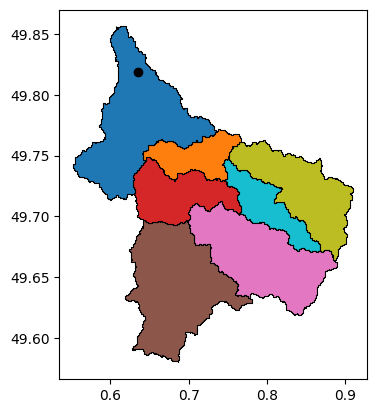

In [8]:
G = G_backup.copy()
gauges_gdf = gauges
flow_dir_path = merit_dirs['flow_dir']
basin_id = megabasin_id

gauge_info = {}
# Track node replacements: old_node_id -> new_gauge_id
node_replacements = {}

# Find which catchment each gauge falls in (INITIAL spatial join only)
catchment_polys = []
node_ids = []
for node_id, data in G.nodes(data=True):
    if data.get("polygon"):
        catchment_polys.append(data["polygon"])
        node_ids.append(node_id)

catchments_gdf = gpd.GeoDataFrame(
    {"node_id": node_ids}, geometry=catchment_polys, crs=gauges_gdf.crs
)

ax = catchments_gdf.plot('node_id', edgecolor='black', linewidth=0.8)
gauges.plot(color='black', ax=ax)

In [9]:
gauges_with_nodes = gpd.sjoin(
    gauges_gdf, catchments_gdf, how="left", predicate="within"
)
# Process from upstream (0.0) to downstream (1.0)
gauges_with_nodes = gauges_with_nodes.sort_values(['node_id', 'position'])
gauge_iter = gauges_with_nodes.iterrows()

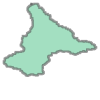

In [10]:
_, gauge = next(gauge_iter)
gauge_id = gauge["id"]
river_position = gauge.get("position")

# Follow the replacement chain to find current node
original_node_id = gauge["node_id"]
current_node_id = original_node_id
while current_node_id in node_replacements:
    current_node_id = node_replacements[current_node_id]

# Get the current polygon (may have been split already)
current_polygon = G.nodes[current_node_id]["polygon"]
current_polygon

In [11]:
catchment_poly = current_polygon
bounds = catchment_poly.bounds
bounds_list = [float(i) for i in bounds]

bounds_list

[0.5529166666666647, 49.713750000000005, 0.7354166666666639, 49.85625]

In [12]:
from numpy import ceil, floor
MERIT_RES = 0.000833333  # 3 arc second resolution in degrees
halfpix = MERIT_RES / 2  # Half pixel width

# Adjust bounds to pixel centers
bounds_list[0] = floor(bounds_list[0] * 1200) / 1200 - halfpix
bounds_list[1] = floor(bounds_list[1] * 1200) / 1200 - halfpix
bounds_list[2] = ceil(bounds_list[2] * 1200) / 1200 + halfpix
bounds_list[3] = ceil(bounds_list[3] * 1200) / 1200 + halfpix
bounding_box = tuple(bounds_list)
bounds_list

[np.float64(0.5520833334999999),
 np.float64(49.71291666683333),
 np.float64(0.7362499998333334),
 np.float64(49.85708333316667)]

In [13]:
megabasin_id

2

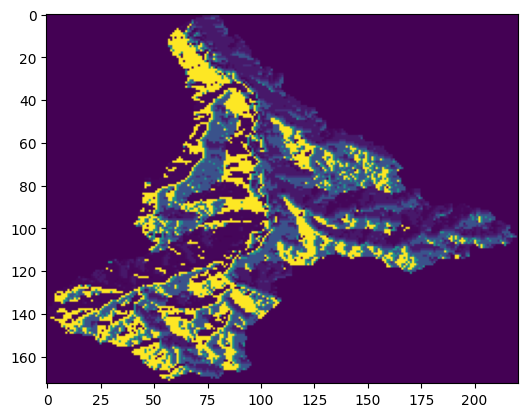

/tmp/ipykernel_1001948/1854635846.py:23: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(facc+0.5))


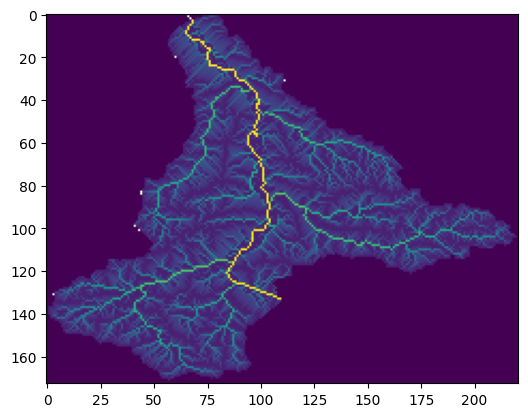

In [14]:
import numpy as np
from pysheds.grid import Grid

pfaf2_id = int(final_comid//1E6)

flow_file = str(flow_dir_path / f"{pfaf2_id}.tif")

grid = Grid.from_raster(flow_file, window=bounding_box, nodata=0)
fdir = grid.read_raster(flow_file, window=bounding_box, nodata=0)

facc_file = str(merit_dirs['flow_acc'] / f"{pfaf2_id}.tif")
facc = grid.read_raster(facc_file, window=bounding_box, nodata=0)


mymask = grid.rasterize([catchment_poly])

fdir[mymask == 0] = 0
facc[mymask == 0] = 0
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)  # ESRI flow direction standard

plt.imshow(fdir)
plt.show()
plt.imshow(np.log10(facc+0.5))
plt.show()

In [33]:
fdir.min()

Raster(0, dtype=uint8)

In [16]:


get_pixel_area_m2(gauge, grid)

5558.6060237288475

In [38]:
min_pixels = min_area * 1E6 / pixel_area_m2
min_pixels

x_snap, y_snap = grid.snap_to_mask(facc > min_pixels, (gauge['lng'], gauge['lat']))

x_snap

np.float64(0.6345833334999988)

In [18]:
gauge.to_dict()

{'id': 'EAUF-G6000610',
 'lng': 0.635322584,
 'lat': 49.818849011,
 'position': 0.3481641967782126,
 'COMID': 23014847,
 'outlet_id': 'EAUF-G6000610',
 'geometry': <POINT (0.635 49.819)>,
 'pfaf1': 2,
 'min_area_km2': 289.4202373684914,
 'max_area_km2': 370.7773446602896,
 'index_right': 6,
 'node_id': '23014847'}

5558.6060237288475

np.float64(52067.053526189884)

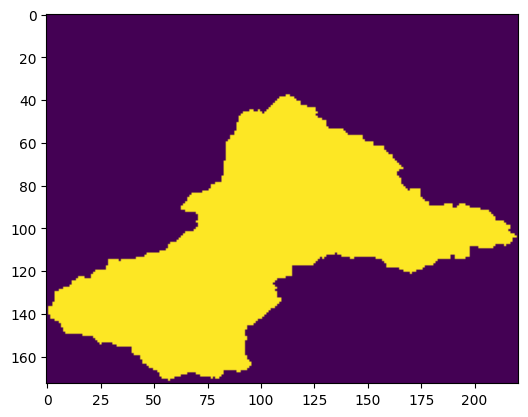

In [36]:
catch = grid.catchment(
    fdir=fdir,
    x=x_snap, 
    y=y_snap,
    dirmap=dirmap,
    xytype="coordinate",
    recursionlimit=15000,
)

plt.imshow(catch)

In [44]:
grid.clip_to(catch)
clipped_catch = grid.view(catch, dtype=np.uint8)

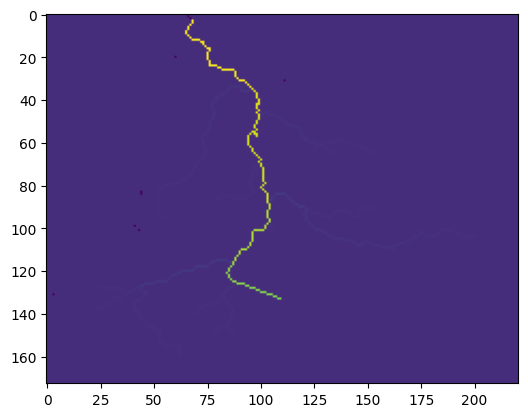

In [51]:
plt.imshow(facc)

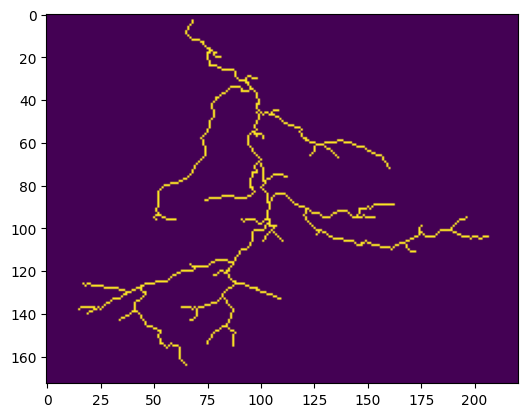

In [68]:
plt.imshow(facc > 100)

In [61]:
facc * catch

Raster([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(173, 221), dtype=int32)

In [62]:
np.log10((facc * catch)+0.5)

Raster([[-0.30103, -0.30103, -0.30103, ..., -0.30103, -0.30103, -0.30103],
        [-0.30103, -0.30103, -0.30103, ..., -0.30103, -0.30103, -0.30103],
        [-0.30103, -0.30103, -0.30103, ..., -0.30103, -0.30103, -0.30103],
        ...,
        [-0.30103, -0.30103, -0.30103, ..., -0.30103, -0.30103, -0.30103],
        [-0.30103, -0.30103, -0.30103, ..., -0.30103, -0.30103, -0.30103],
        [-0.30103, -0.30103, -0.30103, ..., -0.30103, -0.30103, -0.30103]],
       shape=(173, 221))

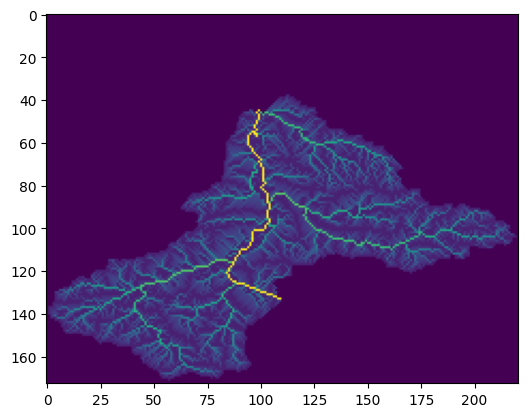

In [66]:
plt.imshow(np.log10((facc * catch)+0.5))

2021


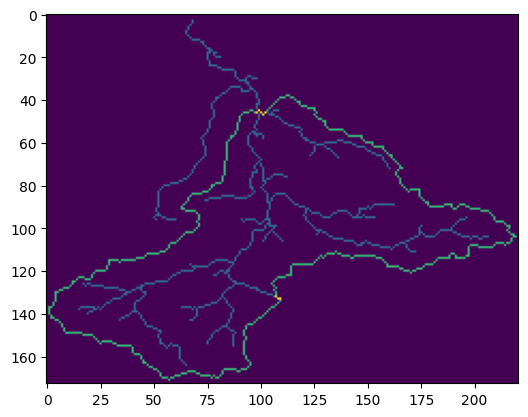

In [84]:
import scipy.ndimage as ndi

# 2. Erode the mask. This "shrinks" it by one pixel.
#    Pixels that were on the edge are set to False.
eroded_mask = ndi.binary_erosion(catch)

# 3. Find the edge by selecting pixels that are in the
#    original mask but *not* in the eroded mask.
catch_edge = catch & ~eroded_mask

# 4. Find pixels that are on the catchment edge AND have acc > 1
outlets_on_edge = (facc > 100) | catch_edge*2

# 5. Count them
num_outlets_on_edge = np.sum(outlets_on_edge)
print(num_outlets_on_edge)

plt.imshow(outlets_on_edge)

3

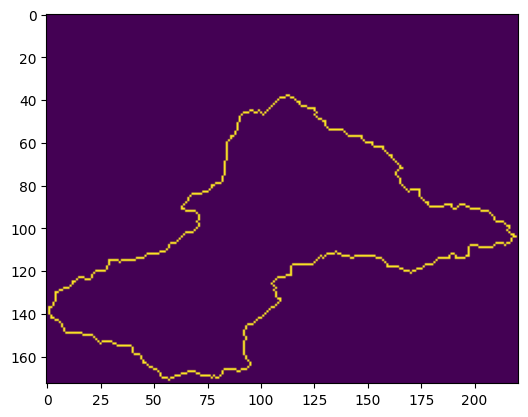

In [76]:
plt.imshow(catch_edge)

In [93]:
acc

Raster([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(133, 160))

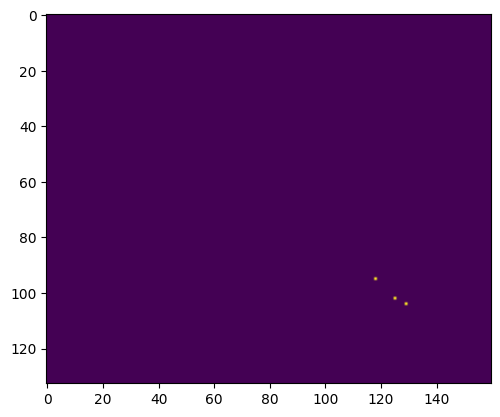

In [84]:
plt.imshow(outlets_on_edge)

In [116]:
type(catch)

pysheds.sview.Raster

Number of flow locations found: 2


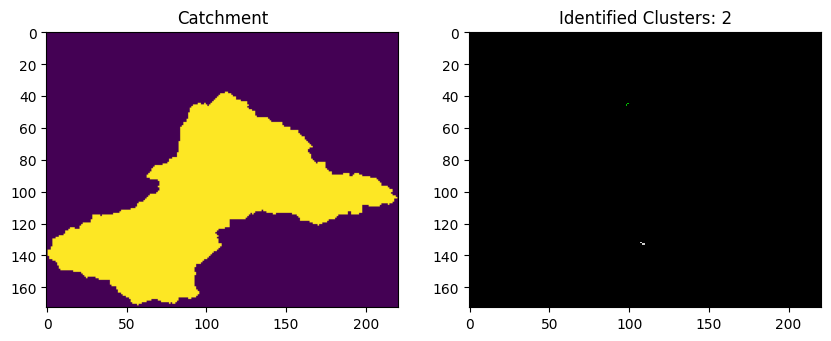

In [46]:
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

# 1. Create the edge mask (as you did)
eroded_mask = ndi.binary_erosion(catch)
catch_edge = catch & ~eroded_mask

# 2. STRICT FILTER: Intersection of Edge AND High Accumulation
# Use '&' not '|'. Adjust threshold (100) based on your resolution.
significant_edge_flow = catch_edge & (facc >= (min_pixels*0.95))

# 3. Label the clusters (Connected Components)
# structure=np.ones((3,3)) allows diagonal connections (8-connectivity)
labeled_array, num_features = ndi.label(significant_edge_flow, structure=np.ones((3,3)))

print(f"Number of flow locations found: {num_features}")

# Visual check
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(catch)
plt.title("Catchment")
plt.subplot(122)
plt.imshow(labeled_array, cmap='nipy_spectral', interpolation='nearest')
plt.title(f"Identified Clusters: {num_features}")
plt.show()

Found 2 flow connections on the edge.
Cluster 1: OUTFLOW (Max Acc: 63518)
Cluster 2: INFLOW (Max Acc: 51952)
Summary: 1 Inflows, 1 Outflows


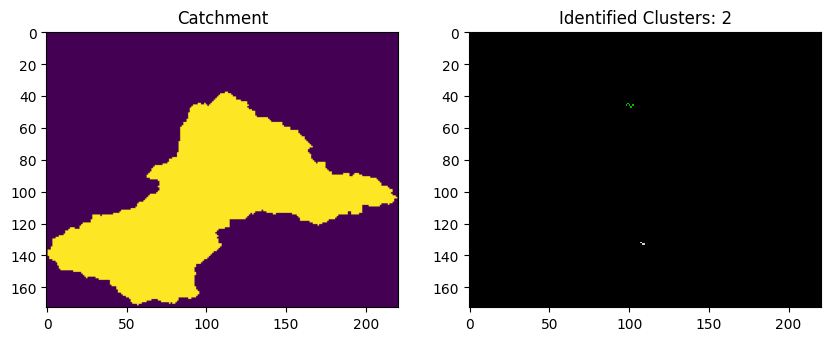

In [109]:
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

# Define ESRI directional offsets: (dy, dx)
# 64:N, 128:NE, 1:E, 2:SE, 4:S, 8:SW, 16:W, 32:NW
esri_offsets = {
    64:  (-1, 0),  128: (-1, 1),
    1:   (0, 1),   2:   (1, 1),
    4:   (1, 0),   8:   (1, -1),
    16:  (0, -1),  32:  (-1, -1)
}

# 1. Erode to find edges
eroded_mask = ndi.binary_erosion(catch)
catch_edge = catch & ~eroded_mask

# 2. Filter: Edge pixels AND High Accumulation (Fixing the bitwise operator)
# Adjust '100' based on your specific resolution/stream threshold requirements
significant_edge_flow = catch_edge & (facc > 100)

# 3. Label clusters
labeled_array, num_features = ndi.label(significant_edge_flow, structure=np.ones((3,3)))

print(f"Found {num_features} flow connections on the edge.")

inflow_count = 0
outflow_count = 0

# 4. Iterate through each cluster to classify
for i in range(1, num_features + 1):
    # Get coordinates of all pixels in this cluster
    y_locs, x_locs = np.where(labeled_array == i)
    
    # Find the pixel with the MAXIMUM flow accumulation in this cluster
    # This is the most reliable point to check (center of the stream)
    cluster_faccs = facc[y_locs, x_locs]
    max_idx = np.argmax(cluster_faccs)
    
    py, px = y_locs[max_idx], x_locs[max_idx]
    direction = fdir[py, px]
    
    # Get the offset for this direction
    dy, dx = esri_offsets.get(direction, (0, 0))
    
    if dy == 0 and dx == 0:
        print(f"Cluster {i}: Sink or Invalid Direction (Val: {direction})")
        continue

    # Calculate target coordinates
    ny, nx = py + dy, px + dx
    
    # Check bounds and mask status
    h, w = catch.shape
    if 0 <= ny < h and 0 <= nx < w:
        target_in_catchment = catch[ny, nx]
    else:
        # If it flows off the grid, it's definitely leaving the catchment
        target_in_catchment = False

    # CLASSIFICATION LOGIC
    if target_in_catchment:
        # If the edge pixel flows INTO the mask, it is an INFLOW
        # (Water arrived here from outside and is continuing in)
        print(f"Cluster {i}: INFLOW (Max Acc: {cluster_faccs[max_idx]})")
        inflow_count += 1
    else:
        # If the edge pixel flows OUT of the mask, it is an OUTFLOW
        print(f"Cluster {i}: OUTFLOW (Max Acc: {cluster_faccs[max_idx]})")
        outflow_count += 1

print(f"Summary: {inflow_count} Inflows, {outflow_count} Outflows")

# Visual check
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(catch)
plt.title("Catchment")
plt.subplot(122)
plt.imshow(labeled_array, cmap='nipy_spectral', interpolation='nearest')
plt.title(f"Identified Clusters: {num_features}")
plt.show()

In [117]:
num_features

2

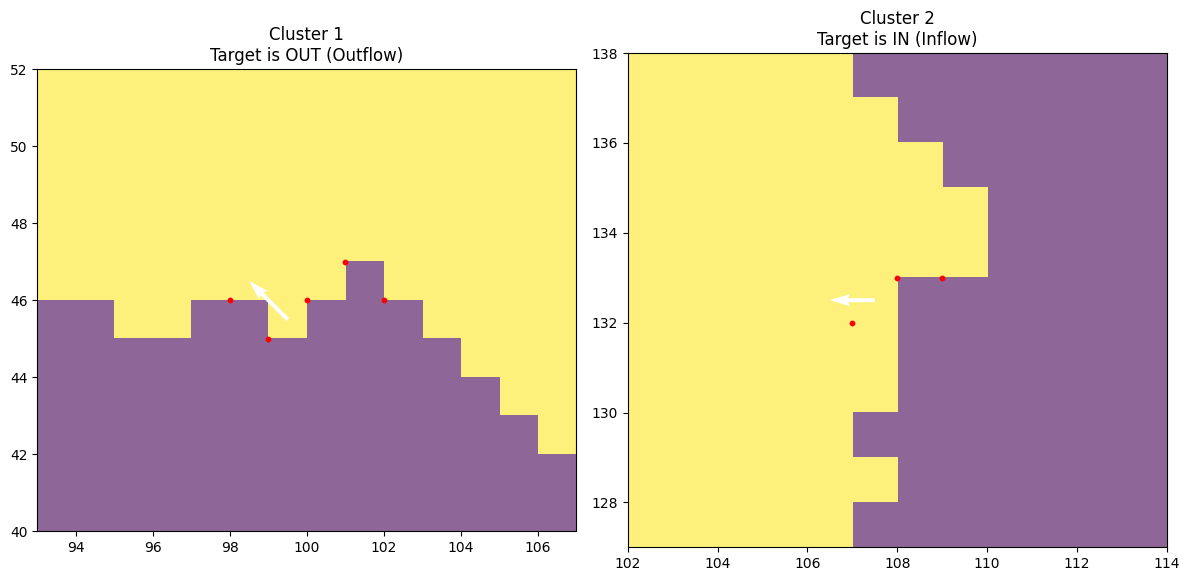

In [112]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Adjust your figure size
plt.figure(figsize=(12, 6))

# Iterate through the clusters found in the previous step
for i in range(1, num_features + 1):
    # 1. Find bounds of this cluster to zoom in
    y_c, x_c = np.where(labeled_array == i)
    
    # Add padding to view context
    pad = 5
    y_min, y_max = np.min(y_c) - pad, np.max(y_c) + pad
    x_min, x_max = np.min(x_c) - pad, np.max(x_c) + pad
    
    # 2. Identify the Critical Pixel (Max Flow Acc)
    cluster_faccs = facc[y_c, x_c]
    max_idx = np.argmax(cluster_faccs)
    py, px = y_c[max_idx], x_c[max_idx]
    
    # 3. Get Flow Vector
    direction = fdir[py, px]
    dy, dx = esri_offsets.get(direction, (0,0))
    
    # Setup Subplot
    ax = plt.subplot(1, num_features, i)
    
    # Plot the Catchment Mask (Yellow=In, Purple=Out)
    subset_mask = catch[y_min:y_max, x_min:x_max]
    ax.imshow(subset_mask, cmap='viridis', alpha=0.6, origin='upper', extent=[x_min, x_max, y_max, y_min])
    
    # Plot the Cluster Pixels (Red)
    ax.scatter(x_c, y_c, c='red', s=10, label='Cluster')
    
    # Plot the Flow Arrow from the Max Facc Pixel
    # Note: Quiver (X, Y, U, V) -> U corresponds to dx (cols), V to -dy (rows, because image y is down)
    ax.quiver(px + 0.5, py + 0.5, dx, -dy, color='white', scale=1, scale_units='xy', angles='xy')
    
    # Highlight the target pixel
    target_y, target_x = py + dy, px + dx
    is_in = catch[target_y, target_x]
    status = "IN (Inflow)" if is_in else "OUT (Outflow)"
    f
    ax.set_title(f"Cluster {i}\nTarget is {status}")
    ax.invert_yaxis() # Align with image coordinates

plt.tight_layout()
plt.show()

In [113]:
facc

Raster([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(173, 221), dtype=int32)

In [90]:
import numpy as np

print(np.unique(fdir))

[  0   1   2   4   8  16  32  64 128]


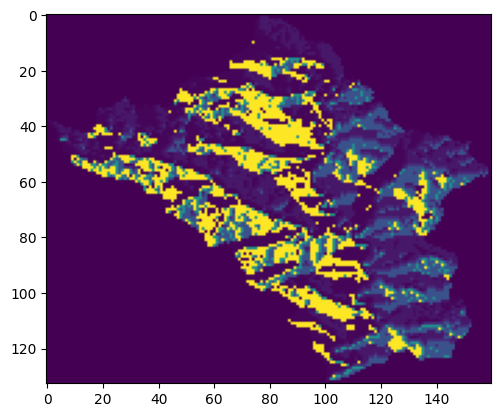

In [24]:
from shapely import wkb
from shapely.geometry import Polygon, MultiPolygon


mymask = grid.rasterize([catchment_poly])

fdir = grid.read_raster(flow_file, window=bounding_box, nodata=0)
m, n = grid.shape
for i in range(m):
    for j in range(n):
        if int(mymask[i, j]) == 0:
            fdir[i, j] = 0

plt.imshow(fdir)

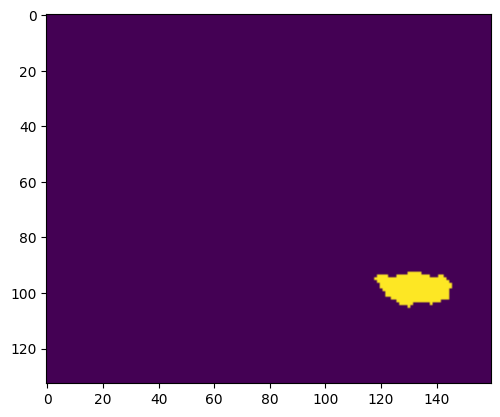

In [25]:
catch = grid.catchment(
    fdir=fdir,
    x=gauge['lng'],
    y=gauge['lat'],
    dirmap=dirmap,
    xytype="coordinate",
    recursionlimit=15000,
)
plt.imshow(catch)

In [26]:
catch

Raster([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]], shape=(133, 160))

id                                 EAUF-N3113010
lng                                    -1.113289
lat                                    46.687029
position                                0.651634
outlet_id                          EAUF-N3301610
geometry       POINT (-1.113289456 46.687028668)
index_right                                   11
node_id                                 23020768
Name: 5413, dtype: object

In [13]:
gauge_polygon = split_catchment_raster(
    gauge_id=gauge_id,
    basin=basin_id,
    lat=gauge["lat"],
    lng=gauge["lng"],
    river_position=river_position,
    catchment_poly=current_polygon,
    flow_dir_path=flow_dir_path,
)

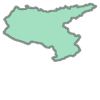

In [14]:
MERIT_RES = 0.000833333  # 3 arc second resolution in degrees

remainder_polygon = current_polygon.difference(gauge_polygon)
remainder_polygon = remainder_polygon.buffer(-MERIT_RES / 2).buffer(MERIT_RES / 2)

remainder_polygon

In [28]:
MERIT_RES * MERIT_RES

6.94443888889e-07

In [27]:
gauge_polygon.area

6.944444444439214e-07

In [9]:
comids

{85008784,
 85008796,
 85008801,
 85008814,
 85008815,
 85008827,
 85008839,
 85008857,
 85008861,
 85008866,
 85008873,
 85008874,
 85008876,
 85008899,
 85008904,
 85008908,
 85008986,
 85008987,
 85008988,
 85008989,
 85008990,
 85008991,
 85008992,
 85008993,
 85008994,
 85008995,
 85008996,
 85008997,
 85008998,
 85009001,
 85009002,
 85009015,
 85009016,
 85009024,
 85009026,
 85009056,
 85009060,
 85009061,
 85009065,
 85009070,
 85009071,
 85009073,
 85009078,
 85009079,
 85009080,
 85009084,
 85009102,
 85009107,
 85009110,
 85009112,
 85009123,
 85009132,
 85009134,
 85009135,
 85009140,
 85009145,
 85009147,
 85009151,
 85009152,
 85009155,
 85009163,
 85009165,
 85009167,
 85009168,
 85009176,
 85009183,
 85009192,
 85009193,
 85009194,
 85009241,
 85009298,
 85009352,
 85009373}

In [ ]:
subbasins, gauges = results['USGS-01059000'].to_geodataframes()

In [ ]:
ax = subbasins[subbasins['is_gauge']].plot('id', alpha=0.8, cmap='inferno')
subbasins.plot(color='grey', ax=ax, zorder=0)
gauges.plot('id', ax=ax, cmap='inferno')#, style_kwds={'markeredgecolor':'black'})

In [6]:
output_dir = Path("/nas/cee-water/cjgleason/ted/graph_delineator/outputs/test")
gd.save_results(results, output_dir, 'test')